# <center> Replication of One of the Simulations from Romero and Rosokha (2019 AEJ:Micro) </center>
### <center> Code by Yaroslav Rosokha </center>

In [1]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import time
import itertools
import pandas as pd

In [2]:
def playMatchM1(s1, s2, p50=50,p12=12,nPer=50):
    
    P=np.array([[38,p12],[p50,25]])
    
    hist1=np.zeros(nPer)
    hist2=np.zeros(nPer)

    for p in range(nPer):
        
        if p==0:
            hist1[p]=s1[0]
            hist2[p]=s2[0]
        else:
            
            if hist1[p-1]==0 and hist2[p-1]==0:
                hist1[p]=s1[1]
                hist2[p]=s2[1]
            elif hist1[p-1]==1 and hist2[p-1]==1:
                hist1[p]=s1[4]
                hist2[p]=s2[4]
            elif hist1[p-1]==0 and hist2[p-1]==1:
                hist1[p]=s1[2]
                hist2[p]=s2[3]
            else:
                hist1[p]=s1[3]
                hist2[p]=s2[2]
                
    
    earnings1=P.take([2*hist1+hist2])
    earnings2=P.take([2*hist2+hist1]) 
    
    return [1-hist1.mean(),earnings1.mean(),1-hist2.mean(),earnings2.mean()]

In [3]:
def binary_array_to_int_np(array):
    # For big-endian interpretation
    return array.dot(1 << np.arange(array.size)[::-1])

In [4]:
#Create all strategies
s1=np.arange(0,2)
iterables = [ s1, s1, s1, s1, s1 ]
strategies=[]
for t in itertools.product(*iterables):
    strategies.append(np.asarray(t))
strategies=np.array(strategies)
n_strategies = len(strategies)


payoffOutcomes=np.zeros((len(strategies),len(strategies)))
cooperOutcomes=np.zeros((len(strategies),len(strategies)))

for i in range(n_strategies):
    for j in range(i, n_strategies):
        results = playMatchM1(strategies[i],strategies[j])
        payoffOutcomes[i,j]=results[1]
        cooperOutcomes[i,j]=results[0]
        payoffOutcomes[j,i]=results[3]
        cooperOutcomes[j,i]=results[2]        

In [5]:
class population():
    
    def __init__(self,nagents,ngen,pmut,lam):

        self.pmut=pmut
        self.lam=lam       
        self.nAgents=nagents
        self.nGen=ngen
        
        self.Gen=np.random.randint(0,2,(nagents,5))
        self.GenI=np.array([binary_array_to_int_np(s) for s in self.Gen])
            
        self.genNumb=0
        self.genEarn=np.zeros(self.nAgents)
        self.genCoop=np.zeros(self.nAgents)
        
        self.timeEarn=np.zeros(self.nGen)
        self.timeCoop=np.zeros(self.nGen)
        self.timeStr=np.zeros((self.nGen,nagents))
            
                
    def genReproduction(self):    

        select_prob=np.exp(self.lam*self.genEarn)/np.sum(np.exp(self.lam*self.genEarn))
        selected=np.random.choice(range(self.nAgents),self.nAgents,p=select_prob)
        self.Gen=cp.deepcopy(self.Gen[selected])
        
    def genMutation(self):
        
        self.Gen=np.abs(self.Gen-np.random.choice([0,1],(self.nAgents,5),p=[1-self.pmut,self.pmut]))   
        
    
    def newRound(self):  
        
        self.genEarn=np.zeros(self.nAgents)
        self.genCoop=np.zeros(self.nAgents)   
        

    def playRound(self):

        subInd=range(self.nAgents)
        
        for i in subInd:
            
            opponentInd=np.delete(subInd,i,axis=0)
            opponentStr=self.GenI[opponentInd]
            myStr=np.repeat(self.GenI[i],self.nAgents-1)
            
            
            self.genEarn[i]=payoffOutcomes.take([32*myStr+opponentStr]).mean()
            self.genCoop[i]=cooperOutcomes.take([32*myStr+opponentStr]).mean()
        
        
    def summarizeRound(self):
        
        self.timeEarn[self.genNumb]=self.genEarn.mean()
        self.timeCoop[self.genNumb]=self.genCoop.mean()
        self.timeStr[self.genNumb,:]=self.GenI
        self.genNumb=self.genNumb+1
        
        
    def evolve(self):
        
        for i in range(self.nGen):
            
            if i>0:
                self.genReproduction()
                self.genMutation()
                self.GenI=np.array([binary_array_to_int_np(s) for s in self.Gen])
            
            self.newRound()
            self.playRound()
            self.summarizeRound()
            
            
    def resetPop(self):
        
        self.Gen=np.random.randint(0,2,(self.nAgents,5))
        self.GenI=np.array([binary_array_to_int_np(s) for s in self.Gen])
            
        self.genNumb=0
        self.genEarn=np.zeros(self.nAgents)
        self.genCoop=np.zeros(self.nAgents)
        
        self.timeEarn=np.zeros(self.nGen)
        self.timeCoop=np.zeros(self.nGen)

In [6]:
nSims=50
nAgents=50
nPer=50
nGen=500


outData={"Generation":[],"AverageCooperation":[],"Simulation":[],"Pmut":[], "Lam":[]}

pmut=[0.01]
lam=[1]


    
for l1 in lam:

    for p1 in pmut:

            p=population(nagents=nAgents,ngen=nGen,pmut=p1,lam=l1)
            coops=np.zeros((nSims,nGen))

            for i in range(nSims):

                print(" pmut=",p1, " lam=",l1," simulation #:",i)

                p.resetPop()
                p.evolve()

                outData['Simulation']=np.append(outData['Simulation'],np.repeat(i,nGen))
                outData['Generation']=np.append(outData['Generation'],range(nGen))
                outData['AverageCooperation']=np.append(outData['AverageCooperation'],p.timeCoop)
                outData['Pmut']=np.append(outData['Pmut'],np.repeat("Pmut="+str(p1),nGen))
                outData['Lam']=np.append(outData['Lam'],np.repeat("Lambda="+str(l1),nGen))

 pmut= 0.01  lam= 1  simulation #: 0
 pmut= 0.01  lam= 1  simulation #: 1
 pmut= 0.01  lam= 1  simulation #: 2
 pmut= 0.01  lam= 1  simulation #: 3
 pmut= 0.01  lam= 1  simulation #: 4
 pmut= 0.01  lam= 1  simulation #: 5
 pmut= 0.01  lam= 1  simulation #: 6
 pmut= 0.01  lam= 1  simulation #: 7
 pmut= 0.01  lam= 1  simulation #: 8
 pmut= 0.01  lam= 1  simulation #: 9
 pmut= 0.01  lam= 1  simulation #: 10
 pmut= 0.01  lam= 1  simulation #: 11
 pmut= 0.01  lam= 1  simulation #: 12
 pmut= 0.01  lam= 1  simulation #: 13
 pmut= 0.01  lam= 1  simulation #: 14
 pmut= 0.01  lam= 1  simulation #: 15
 pmut= 0.01  lam= 1  simulation #: 16
 pmut= 0.01  lam= 1  simulation #: 17
 pmut= 0.01  lam= 1  simulation #: 18
 pmut= 0.01  lam= 1  simulation #: 19
 pmut= 0.01  lam= 1  simulation #: 20
 pmut= 0.01  lam= 1  simulation #: 21
 pmut= 0.01  lam= 1  simulation #: 22
 pmut= 0.01  lam= 1  simulation #: 23
 pmut= 0.01  lam= 1  simulation #: 24
 pmut= 0.01  lam= 1  simulation #: 25
 pmut= 0.01  lam= 1  s

In [7]:
df = pd.DataFrame(outData)

In [8]:
df.head()

,Generation,AverageCooperation,Simulation,Pmut,Lam
0,0.0,0.464939,0.0,Pmut=0.01,Lambda=1
1,1.0,0.039192,0.0,Pmut=0.01,Lambda=1
2,2.0,0.003624,0.0,Pmut=0.01,Lambda=1
3,3.0,0.022065,0.0,Pmut=0.01,Lambda=1
4,4.0,0.000400,0.0,Pmut=0.01,Lambda=1


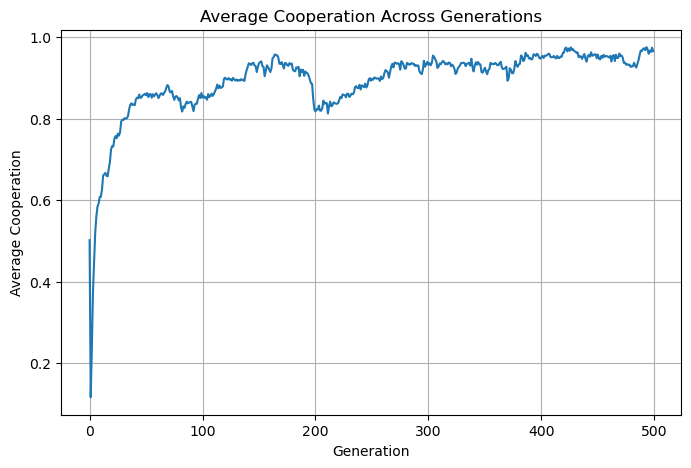

In [9]:
# Group by 'Generation' and calculate the mean 'AverageCooperation'
average_cooperation_per_gen = df.groupby('Generation')['AverageCooperation'].mean()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(average_cooperation_per_gen.index, average_cooperation_per_gen.values)

plt.title('Average Cooperation Across Generations')
plt.xlabel('Generation')
plt.ylabel('Average Cooperation')
plt.grid(True)

plt.show()

### Step-by-Step Example

In [10]:
p=population(nagents=nAgents,ngen=nGen,pmut=p1,lam=l1)

In [11]:
p.Gen

array([[1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0],
       [1, 1, 1, 0, 1],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1],
       [1, 1, 1, 0, 1],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 1, 1, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 0, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 1, 0,

In [12]:
p.playRound()

In [13]:
p.genEarn

array([25.61632653, 30.61346939, 31.59755102, 37.52040816, 30.61346939,
       25.58530612, 24.46938776, 37.69387755, 34.29387755, 27.45918367,
       36.08938776, 37.69387755, 24.46938776, 32.52040816, 35.81102041,
       25.58530612, 31.59755102, 36.08938776, 24.46938776, 35.81102041,
       37.69387755, 36.08938776, 31.74040816, 27.45918367, 31.59755102,
       24.46938776, 32.52040816, 24.46938776, 37.52040816, 32.41265306,
       25.61632653, 37.48530612, 31.59755102, 31.46408163, 37.52040816,
       31.46408163, 32.52040816, 37.52040816, 37.52040816, 37.52040816,
       30.61346939, 28.25632653, 32.41265306, 25.45795918, 36.74979592,
       25.58530612, 25.76979592, 25.58530612, 24.46938776, 27.45918367])